In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import linalg as LA
import copy
import networkx as nx
import random
import matplotlib.ticker as ticker
from scipy.stats import pearsonr

plt.rcParams.update({'font.size': 17})

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
"""
Read correlation matrix
The correlation matrix represents spearman correlation between every pair of genes in source and target tissue.
"""
corr_data = abs(pd.read_csv("../data/insulin_eQTL_spearman_corr_matrix_with_snap_removed_CF_lt_R_latest_10k_partial_cov.csv"))
#prob_data = pd.read_csv("../data/insulin_eQTL_spearman_prob_matrix_adj_removed_CF_lt_R_latest_10k.csv")
corr_data

,RPL10P15,CYP17A1,RP1-197B17.7,PHF24,GNG3,NPPA,SYCE1,RP11-286H14.4,RP11-187C18.3,RPL29P12,...,STX5.1,EIF5A.1,MAPK7.1,HIPK1.1,STK36.1,POMGNT1.1,RRS1.1,NDUFAF7.1,PIK3CD.1,CAP1.1
RPL10P15,1.000000,0.053434,0.043760,0.050054,0.035954,0.046822,0.035239,0.118408,0.005489,0.194413,...,0.000727,0.070111,0.073198,0.065885,0.031846,0.003094,0.060211,0.075776,0.047379,0.066268
CYP17A1,0.053434,1.000000,0.040780,0.010423,0.114900,0.010247,0.052217,0.036745,0.136705,0.172469,...,0.007358,0.125375,0.057436,0.041594,0.071905,0.098046,0.037525,0.060133,0.018366,0.050969
RP1-197B17.7,0.043760,0.040780,1.000000,0.053669,0.104990,0.109487,0.113065,0.001620,0.075315,0.003869,...,0.014127,0.099711,0.008239,0.014327,0.031850,0.113746,0.032206,0.144107,0.038195,0.176731
PHF24,0.050054,0.010423,0.053669,1.000000,0.238854,0.046769,0.065840,0.034841,0.051371,0.001902,...,0.024330,0.034334,0.037916,0.001487,0.014788,0.052408,0.046394,0.075549,0.013842,0.057242
GNG3,0.035954,0.114900,0.104990,0.238854,1.000000,0.013479,0.028680,0.068333,0.071739,0.024476,...,0.134748,0.007479,0.062852,0.035041,0.045977,0.070340,0.083501,0.060685,0.042746,0.014760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POMGNT1,0.003094,0.098046,0.113746,0.052408,0.070340,0.051227,0.018045,0.004307,0.041205,0.021201,...,0.065954,0.256484,0.084094,0.000366,0.009958,1.000000,0.096197,0.046823,0.042183,0.231971
RRS1,0.060211,0.037525,0.032206,0.046394,0.083501,0.061765,0.000168,0.039143,0.074213,0.052205,...,0.253314,0.187179,0.146618,0.049679,0.103293,0.096197,1.000000,0.007978,0.070975,0.027322
NDUFAF7,0.075776,0.060133,0.144107,0.075549,0.060685,0.022735,0.059743,0.046151,0.000834,0.062077,...,0.067235,0.044782,0.029135,0.063853,0.046101,0.046823,0.007978,1.000000,0.124829,0.166220
PIK3CD,0.047379,0.018366,0.038195,0.013842,0.042746,0.060825,0.068878,0.037072,0.063950,0.064314,...,0.000115,0.009649,0.080346,0.028597,0.069386,0.042183,0.070975,0.124829,1.000000,0.080262


In [3]:
"""
Check dimensions of the correlaiton matrix
"""

N = int(corr_data.shape[0])
L = 2
n = int(N/L)

In [4]:
"""
Read source and target genes and print their statistics
"""

genes = list(corr_data.columns[:n])
target_genes = list(pd.read_csv('../data/insulin_target_genes_full.csv', header=None).iloc[:,0])
source_genes = list(pd.read_csv('../data/insulin_source_genes_full.csv', header=None).iloc[:,0])

print("Statistics of the ground truth data")
print("Number of genes: ", len(genes))
print("Number of target genes: ", len(target_genes))
print("Number of source genes: ", len(source_genes))
#print(genes)

common_target_genes = np.intersect1d(genes, target_genes)
common_source_genes = np.intersect1d(genes, source_genes)


print("Number of target genes present in the data: ", len(common_target_genes))
print("Number of source genes present in the data: ", len(common_source_genes))

target_genes_indices = [i for i, e in enumerate(genes) if e in common_target_genes]
source_genes_indices = [i for i, e in enumerate(genes) if e in common_source_genes]

print("Number of target genes present in the data: ", len(target_genes_indices))
print("Number of source genes present in the data: ", len(source_genes_indices))

print(target_genes_indices)

Statistics of the ground truth data
Number of genes:  14459
Number of target genes:  6482
Number of source genes:  2860
Number of target genes present in the data:  215
Number of source genes present in the data:  156
Number of target genes present in the data:  215
Number of source genes present in the data:  156
[5, 14, 1098, 1135, 1350, 1435, 1447, 1453, 1641, 1938, 2085, 2087, 2097, 2373, 2384, 2479, 2554, 2560, 2643, 2859, 2883, 3097, 3177, 3317, 3399, 3418, 3611, 3618, 3662, 3717, 3967, 4061, 4255, 4274, 4418, 4549, 4627, 4693, 5121, 5224, 5379, 5483, 5630, 5654, 5713, 6020, 6109, 6111, 6169, 6249, 6258, 6324, 6434, 6630, 6731, 6853, 6860, 6892, 6997, 7176, 7282, 7373, 7394, 7462, 7511, 7596, 7710, 7750, 7843, 7872, 7875, 8066, 8336, 8360, 8454, 8472, 8523, 8584, 8589, 8605, 8665, 8742, 8746, 8764, 8852, 8969, 9157, 9258, 9268, 9363, 9364, 9540, 9592, 9600, 9716, 9730, 9735, 9748, 9761, 9836, 9871, 9933, 10049, 10057, 10089, 10145, 10237, 10241, 10345, 10500, 10560, 10612, 10620,

In [5]:
"""
Read data from SNAP repository
"""


SNAP_data = pd.read_csv("../data/SNAP_data/PPT-Ohmnet_gene_symbols.csv", index_col=0)
#SNAP_data
pancreas_df = SNAP_data.loc[SNAP_data['tissue'] == "pancreas"].values
skeletal_muscle_df = SNAP_data.loc[SNAP_data['tissue'] == "skeletal_muscle"].values

A_SNAP = np.zeros_like(corr_data.values, dtype=np.float32)

#skeletal_muscle_adjacency = np.zeros_like((np.shape(skeletal_muscle_df)[0], 2))
for i in range(np.shape(skeletal_muscle_df)[0]):
    n_offset = n
    try:
        from_gene = int(genes.index(skeletal_muscle_df[i,0])) + n_offset
        to_gene = int(genes.index(skeletal_muscle_df[i,1])) + n_offset    
        A_SNAP[from_gene, to_gene] = 1
        A_SNAP[to_gene, from_gene] = 1
    except:
        print("In skeletal muscle ", skeletal_muscle_df[i, 0], " or ", skeletal_muscle_df[i,1], " not present.")             
    

for i in range(np.shape(pancreas_df)[0]):
    n_offset = 0
    try:
        from_gene = int(genes.index(pancreas_df[i,0])) + n_offset
        to_gene = int(genes.index(pancreas_df[i,1])) + n_offset    
        A_SNAP[from_gene, to_gene] = 1
        A_SNAP[to_gene, from_gene] = 1
    except:
        print("In pancreas ", pancreas_df[i, 0], " or ", pancreas_df[i,1], " not present.")  


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In skeletal muscle  SETDB1  or  H4-16  not present.
In skeletal muscle  SEPTIN9  or  VAPB  not present.
In skeletal muscle  NKX3-2  or  TLE4  not present.
In skeletal muscle  MYOD1  or  RUNX1  not present.
In skeletal muscle  NPM1  or  ATP5F1A  not present.
In skeletal muscle  MRE11  or  FEN1  not present.
In skeletal muscle  RBPMS  or  TENT2  not present.
In skeletal muscle  ATP5F1D  or  ATP5F1C  not present.
In skeletal muscle  PPP1CA  or  PRKACG  not present.
In skeletal muscle  GCK  or  GMIP  not present.
In skeletal muscle  ERCC4  or  H2AX  not present.
In skeletal muscle  TLE5  or  RNF31  not present.
In skeletal muscle  GRB2  or  DENND2B  not present.
In skeletal muscle  FOXA3  or  DSP  not present.
In skeletal muscle  H4-16  or  KDM4A  not present.
In skeletal muscle  OBSL1  or  MRE11  not present.
In skeletal muscle  CREB3  or  BIK  not present.
In skeletal muscle  ACTN3  or  LHX3  not present.
In skeletal muscle  PRKN  or  EPS15  not present.
In skeletal muscle  PRKN  or  NME

In skeletal muscle  CDK2  or  ATP5MG  not present.
In skeletal muscle  TAFAZZIN  or  COL6A2  not present.
In skeletal muscle  PSMA2  or  ECPAS  not present.
In skeletal muscle  GRB2  or  H4C2  not present.
In skeletal muscle  ZACN  or  EDA  not present.
In skeletal muscle  H4C11  or  SMARCA5  not present.
In skeletal muscle  HDAC1  or  H4C12  not present.
In skeletal muscle  JUN  or  SHANK1  not present.
In skeletal muscle  TRIM23  or  ATP5PF  not present.
In skeletal muscle  TNFRSF1A  or  H4C9  not present.
In skeletal muscle  RDH12  or  UBE2D2  not present.
In skeletal muscle  PRKN  or  PSME1  not present.
In skeletal muscle  NCOA3  or  MRTFA  not present.
In skeletal muscle  MAPK1  or  STAB2  not present.
In skeletal muscle  H2AX  or  HEXA  not present.
In skeletal muscle  HDAC1  or  H4C5  not present.
In skeletal muscle  L3MBTL1  or  H4C12  not present.
In skeletal muscle  TFEB  or  ATP5PF  not present.
In skeletal muscle  BMI1  or  ATP5ME  not present.
In skeletal muscle  MRPL58  

In skeletal muscle  COPS5  or  H4C11  not present.
In skeletal muscle  NRG1  or  ATP7B  not present.
In skeletal muscle  PFKL  or  PRKACG  not present.
In skeletal muscle  CAND1  or  H4C12  not present.
In skeletal muscle  CBLC  or  ITCH  not present.
In skeletal muscle  CD81  or  ATP5PO  not present.
In skeletal muscle  RB1CC1  or  NSD3  not present.
In skeletal muscle  PFKM  or  CAV3  not present.
In skeletal muscle  ECPAS  or  MARCHF5  not present.
In skeletal muscle  NASP  or  H4C1  not present.
In skeletal muscle  MAPK1  or  GATA4  not present.
In skeletal muscle  MAP3K1  or  H4C5  not present.
In skeletal muscle  EGFR  or  ATP5PB  not present.
In skeletal muscle  PIK3CA  or  ATP5IF1  not present.
In skeletal muscle  NPHP1  or  DNAAF10  not present.
In skeletal muscle  TLE5  or  TCF7L2  not present.
In skeletal muscle  PRKN  or  STUB1  not present.
In skeletal muscle  APP  or  ATP5PO  not present.
In skeletal muscle  PGAM2  or  MDM2  not present.
In skeletal muscle  ATP6V0D1  or  

In skeletal muscle  XPO1  or  PHETA1  not present.
In skeletal muscle  HDAC5  or  H4C2  not present.
In skeletal muscle  NRG1  or  INTS7  not present.
In skeletal muscle  ATF2  or  ATP5F1B  not present.
In skeletal muscle  CCN2  or  ACTG1  not present.
In skeletal muscle  ERBB3  or  NRG1  not present.
In skeletal muscle  BRD7  or  H4C8  not present.
In skeletal muscle  MCM2  or  ATP5PO  not present.
In skeletal muscle  COPS5  or  H4C12  not present.
In skeletal muscle  IGF2BP1  or  HSP90AB1  not present.
In skeletal muscle  NEDD4  or  BRCA2  not present.
In skeletal muscle  APEX1  or  HOXC13  not present.
In skeletal muscle  BAHD1  or  MEGF10  not present.
In skeletal muscle  H2AX  or  POFUT1  not present.
In skeletal muscle  H4-16  or  ARRB1  not present.
In skeletal muscle  MESD  or  RPS6KA4  not present.
In skeletal muscle  LIG4  or  MRE11  not present.
In skeletal muscle  ATP5PO  or  ATP5ME  not present.
In skeletal muscle  TOPBP1  or  MRE11  not present.
In skeletal muscle  MAP3K1

In skeletal muscle  CARD8  or  BRCA2  not present.
In skeletal muscle  SGO1  or  DNMT3B  not present.
In skeletal muscle  ATP5F1B  or  ATP5MF  not present.
In skeletal muscle  H2AX  or  CALR  not present.
In skeletal muscle  COPS5  or  H4C6  not present.
In skeletal muscle  GOLT1B  or  ATP5PO  not present.
In skeletal muscle  MARCHF6  or  DIO2  not present.
In skeletal muscle  GLUL  or  CASP8AP2  not present.
In skeletal muscle  TRAF2  or  NMUR2  not present.
In skeletal muscle  CHRM2  or  GNA11  not present.
In skeletal muscle  NEK1  or  MRE11  not present.
In skeletal muscle  SYK  or  SLC4A1  not present.
In skeletal muscle  SMARCA4  or  H4C6  not present.
In skeletal muscle  TLE5  or  SUFU  not present.
In skeletal muscle  XPO1  or  ECPAS  not present.
In skeletal muscle  COPRS  or  H4C5  not present.
In skeletal muscle  AARS1  or  STAT1  not present.
In skeletal muscle  FOXA3  or  STOM  not present.
In skeletal muscle  CASP8AP2  or  CASP8  not present.
In skeletal muscle  MEGF10  o

In skeletal muscle  NKX3-2  or  TLE2  not present.
In skeletal muscle  TLE5  or  SNCAIP  not present.
In skeletal muscle  WASL  or  UBASH3A  not present.
In skeletal muscle  BAZ1B  or  H2AX  not present.
In skeletal muscle  TRRAP  or  MRE11  not present.
In skeletal muscle  BRD7  or  H4C1  not present.
In skeletal muscle  ACTN3  or  CTDSP1  not present.
In skeletal muscle  TGFB1  or  SNAI1  not present.
In skeletal muscle  MRTFA  or  SMAD3  not present.
In skeletal muscle  COPS5  or  H4-16  not present.
In skeletal muscle  AGO4  or  IGF2BP1  not present.
In skeletal muscle  MYC  or  IGF2BP1  not present.
In skeletal muscle  DAXX  or  H4C12  not present.
In skeletal muscle  YBX1  or  ATP5F1C  not present.
In skeletal muscle  OBSL1  or  H4C13  not present.
In skeletal muscle  ATP5MG  or  MYH9  not present.
In skeletal muscle  BAG3  or  OVOL2  not present.
In skeletal muscle  DHX9  or  MRE11  not present.
In skeletal muscle  PRKN  or  LMNA  not present.
In skeletal muscle  WNT2  or  SFRP1

In skeletal muscle  CLP1  or  YJU2B  not present.
In skeletal muscle  PRKN  or  UBASH3A  not present.
In skeletal muscle  MESD  or  APP  not present.
In skeletal muscle  H4C1  or  HDAC1  not present.
In skeletal muscle  FN1  or  H4C5  not present.
In skeletal muscle  PRKACG  or  VDR  not present.
In skeletal muscle  PIK3R2  or  KRT9  not present.
In skeletal muscle  CDH3  or  CTNNB1  not present.
In skeletal muscle  H2AX  or  CTSD  not present.
In skeletal muscle  FOXA3  or  ERAL1  not present.
In skeletal muscle  MEGF10  or  CADPS2  not present.
In skeletal muscle  ATP5F1C  or  NDUFS1  not present.
In skeletal muscle  YWHAH  or  EXO1  not present.
In skeletal muscle  HDAC1  or  H4C13  not present.
In skeletal muscle  ATP5PB  or  VDAC1  not present.
In skeletal muscle  ITGAV  or  CCN1  not present.
In skeletal muscle  ATP5F1A  or  ATP5PF  not present.
In skeletal muscle  CEP152  or  WASHC1  not present.
In skeletal muscle  AARS1  or  TPD52  not present.
In skeletal muscle  HSP90AA1  or

In skeletal muscle  H4-16  or  PABPC1  not present.
In skeletal muscle  MCC  or  DNAAF4  not present.
In skeletal muscle  MRE11  or  PTBP1  not present.
In skeletal muscle  TLE5  or  HNRNPF  not present.
In skeletal muscle  TLE5  or  HNRNPAB  not present.
In skeletal muscle  HNRNPM  or  ECPAS  not present.
In skeletal muscle  FBXO6  or  H4C15  not present.
In skeletal muscle  RPA2  or  BRCA2  not present.
In skeletal muscle  VDAC3  or  ATP5ME  not present.
In skeletal muscle  ATP5MF  or  NECTIN2  not present.
In skeletal muscle  MSH2  or  EXO1  not present.
In skeletal muscle  COPRS  or  H4C9  not present.
In skeletal muscle  SEM1  or  SAC3D1  not present.
In skeletal muscle  BRD4  or  H4C1  not present.
In skeletal muscle  ATP5F1B  or  NDUFA12  not present.
In skeletal muscle  ATP5PB  or  KDM1A  not present.
In skeletal muscle  ATR  or  H2AX  not present.
In skeletal muscle  ATP5PB  or  SGPL1  not present.
In skeletal muscle  SGO1  or  PPM1A  not present.
In skeletal muscle  MYOD1  or

In skeletal muscle  MYOG  or  CALM3  not present.
In skeletal muscle  ATP5F1E  or  ATP5PO  not present.
In skeletal muscle  SMCHD1  or  WARS1  not present.
In skeletal muscle  CUL3  or  H4C15  not present.
In skeletal muscle  GATA4  or  HAND2  not present.
In skeletal muscle  PRKN  or  UBE2E1  not present.
In skeletal muscle  FN1  or  H4C8  not present.
In skeletal muscle  TOPBP1  or  H4C14  not present.
In skeletal muscle  VDAC3  or  ATP5PD  not present.
In skeletal muscle  IKBKG  or  PRKN  not present.
In skeletal muscle  NCL  or  ATP5F1A  not present.
In skeletal muscle  ATP5PO  or  SLX4  not present.
In skeletal muscle  WARS1  or  CTSD  not present.
In skeletal muscle  CAND1  or  H4C6  not present.
In skeletal muscle  SGO1  or  KAT6B  not present.
In skeletal muscle  CCN2  or  FN1  not present.
In skeletal muscle  GATA4  or  ZFPM2  not present.
In skeletal muscle  HNRNPA1  or  IGF2BP1  not present.
In skeletal muscle  LRRK2  or  ATP5MG  not present.
In skeletal muscle  HDAC3  or  H

In skeletal muscle  L3MBTL1  or  H4C15  not present.
In skeletal muscle  FOXE1  or  DSP  not present.
In skeletal muscle  TGFB1  or  TGFB1  not present.
In skeletal muscle  CAPRIN1  or  MRE11  not present.
In skeletal muscle  NCL  or  SEPTIN9  not present.
In skeletal muscle  FHL2  or  A1CF  not present.
In skeletal muscle  IGF2BP1  or  GTPBP4  not present.
In skeletal muscle  MYH9  or  SEPTIN7  not present.
In skeletal muscle  TNFRSF1A  or  H4C14  not present.
In skeletal muscle  PRKN  or  FIS1  not present.
In skeletal muscle  MARCHF5  or  UBE2D3  not present.
In skeletal muscle  NCK1  or  PAX7  not present.
In skeletal muscle  ATP5F1A  or  MYH9  not present.
In skeletal muscle  MYOG  or  MEF2A  not present.
In skeletal muscle  DTX3L  or  H4C1  not present.
In skeletal muscle  PIK3R1  or  SLC9A2  not present.
In skeletal muscle  HDAC1  or  BRCA2  not present.
In skeletal muscle  FYN  or  PAX3  not present.
In skeletal muscle  ACTN4  or  ACTN3  not present.
In skeletal muscle  PRKN  o

In skeletal muscle  HDAC5  or  H4-16  not present.
In skeletal muscle  H2AX  or  YWHAH  not present.
In skeletal muscle  MRE11  or  MSH6  not present.
In skeletal muscle  TAFAZZIN  or  RUNX1  not present.
In skeletal muscle  DHRS2  or  ANXA1  not present.
In skeletal muscle  TLE5  or  TRAF2  not present.
In skeletal muscle  HUWE1  or  MRE11  not present.
In skeletal muscle  KMT5A  or  H4C1  not present.
In skeletal muscle  NUDT21  or  MRE11  not present.
In skeletal muscle  MARCHF5  or  UBE2D2  not present.
In skeletal muscle  SRSF10  or  ATP5F1C  not present.
In skeletal muscle  EPS15  or  KRT9  not present.
In skeletal muscle  IGF2BP1  or  HNRNPM  not present.
In skeletal muscle  UBE2L3  or  CBLC  not present.
In skeletal muscle  PRKN  or  UBE2G1  not present.
In skeletal muscle  H2AX  or  AIFM1  not present.
In skeletal muscle  FN1  or  H4C11  not present.
In skeletal muscle  YWHAH  or  TWNK  not present.
In skeletal muscle  DOCK7  or  NSD3  not present.
In skeletal muscle  SEPTIN5 

In skeletal muscle  SIX2  or  TLE5  not present.
In skeletal muscle  PPP2CA  or  SGO1  not present.
In skeletal muscle  NOX1  or  TNFRSF1A  not present.
In skeletal muscle  GSK3A  or  PRKACG  not present.
In skeletal muscle  ELP1  or  FLNA  not present.
In skeletal muscle  DHRS2  or  HSP90AB1  not present.
In skeletal muscle  HDAC1  or  NSD2  not present.
In skeletal muscle  H2AX  or  YWHAG  not present.
In skeletal muscle  FOXE1  or  LDB1  not present.
In skeletal muscle  LMX1A  or  BMPR2  not present.
In skeletal muscle  SKI  or  ATP5PO  not present.
In skeletal muscle  SLC4A1  or  ANK1  not present.
In skeletal muscle  PRKN  or  VDAC3  not present.
In skeletal muscle  PRKACG  or  CAPN2  not present.
In skeletal muscle  ATP5F1A  or  ATP5F1C  not present.
In skeletal muscle  ATXN1  or  WASHC2C  not present.
In skeletal muscle  CCN1  or  ITGB1  not present.
In skeletal muscle  APC  or  PRKACG  not present.
In skeletal muscle  FN1  or  H4C4  not present.
In skeletal muscle  ATP5MG  or  

In skeletal muscle  PRKN  or  VIM  not present.
In skeletal muscle  FN1  or  H4C6  not present.
In skeletal muscle  COPRS  or  H4C2  not present.
In skeletal muscle  SEPTIN5  or  APP  not present.
In skeletal muscle  TAFAZZIN  or  GSK3B  not present.
In skeletal muscle  ATP5PO  or  ANXA7  not present.
In skeletal muscle  MEGF10  or  GRB10  not present.
In skeletal muscle  HUWE1  or  ATP5F1A  not present.
In skeletal muscle  H2AX  or  HSP90B1  not present.
In skeletal muscle  NCOA3  or  BABAM2  not present.
In skeletal muscle  UBE2H  or  CBLC  not present.
In skeletal muscle  SEM1  or  EEF1A2  not present.
In skeletal muscle  SEPTIN11  or  SF1  not present.
In skeletal muscle  PRMT5  or  H4C5  not present.
In skeletal muscle  H2AX  or  PPIA  not present.
In skeletal muscle  SMARCA5  or  H4C1  not present.
In skeletal muscle  H4C2  or  SMARCA5  not present.
In skeletal muscle  GATA4  or  EZH2  not present.
In skeletal muscle  UIMC1  or  ECPAS  not present.
In skeletal muscle  LHX1  or  L

In skeletal muscle  CALCOCO2  or  TENT2  not present.
In skeletal muscle  PALB2  or  BRCA2  not present.
In skeletal muscle  FOXA3  or  SMPD4  not present.
In skeletal muscle  OVCA2  or  PTPN11  not present.
In skeletal muscle  JAK2  or  SH2B2  not present.
In skeletal muscle  CREBBP  or  H4-16  not present.
In skeletal muscle  HDAC5  or  H4C4  not present.
In skeletal muscle  SERPINH1  or  BRCA2  not present.
In skeletal muscle  BRAF  or  NSD2  not present.
In skeletal muscle  ILK  or  ATP5ME  not present.
In skeletal muscle  GRIK2  or  PRKACG  not present.
In skeletal muscle  NCOA3  or  MRTFB  not present.
In skeletal muscle  CUL1  or  KRT9  not present.
In skeletal muscle  CUL4A  or  IGF2BP1  not present.
In skeletal muscle  ERCC3  or  MRE11  not present.
In skeletal muscle  PRMT5  or  H4C6  not present.
In skeletal muscle  HSP90AB1  or  AARS1  not present.
In skeletal muscle  ECPAS  or  TUBB  not present.
In skeletal muscle  MRE11  or  PRMT1  not present.
In skeletal muscle  KIF2A 

In skeletal muscle  H4C13  or  KDM4A  not present.
In skeletal muscle  DHRS2  or  YBX1  not present.
In skeletal muscle  DLG4  or  SHANK1  not present.
In skeletal muscle  ATP5F1D  or  ATP5MF  not present.
In skeletal muscle  ATP5PF  or  PARK7  not present.
In skeletal muscle  HDAC5  or  H4C5  not present.
In skeletal muscle  MYOD1  or  SNW1  not present.
In skeletal muscle  BRCA1  or  H4C6  not present.
In skeletal muscle  PPP1CB  or  PRKACG  not present.
In skeletal muscle  NRG1  or  ERBB2  not present.
In skeletal muscle  H4C8  or  SMARCA5  not present.
In skeletal muscle  H2AX  or  CUL1  not present.
In skeletal muscle  PRKN  or  MRPL12  not present.
In skeletal muscle  SALL3  or  DNMT3A  not present.
In skeletal muscle  HNRNPU  or  SEPTIN7  not present.
In skeletal muscle  PPP1CC  or  PRKACG  not present.
In skeletal muscle  PRKN  or  VCP  not present.
In skeletal muscle  LHX3  or  TSEN54  not present.
In skeletal muscle  TCF3  or  MYF5  not present.
In skeletal muscle  DHRS2  or 

In skeletal muscle  ATP5F1D  or  RIPK2  not present.
In skeletal muscle  SIAH1  or  H4-16  not present.
In skeletal muscle  HNRNPH1  or  ATP5F1A  not present.
In skeletal muscle  BRCA1  or  H4C4  not present.
In skeletal muscle  PPP2CB  or  SGO1  not present.
In skeletal muscle  MYOD1  or  CREB1  not present.
In skeletal muscle  OBSL1  or  ATP5F1A  not present.
In skeletal muscle  MRE11  or  CHAMP1  not present.
In skeletal muscle  ATP5F1A  or  NDUFS4  not present.
In skeletal muscle  OCRL  or  LHX3  not present.
In skeletal muscle  HDAC1  or  H4C6  not present.
In skeletal muscle  TOPORS  or  H2AX  not present.
In skeletal muscle  PRKN  or  TOMM22  not present.
In skeletal muscle  PHGDH  or  PGAM2  not present.
In skeletal muscle  CHD1L  or  H2AX  not present.
In skeletal muscle  FOXE1  or  SMARCA1  not present.
In skeletal muscle  TRAF2  or  KIF26B  not present.
In skeletal muscle  H4C15  or  BRCA1  not present.
In skeletal muscle  P2RY12  or  ATP5F1B  not present.
In skeletal muscle

In pancreas  UCHL5  or  H4C6  not present.
In pancreas  H2AX  or  ANXA6  not present.
In pancreas  ARRB2  or  PAK5  not present.
In pancreas  MARCHF2  or  UBE2H  not present.
In pancreas  HNF4A  or  TAF6  not present.
In pancreas  PCM1  or  ECPAS  not present.
In pancreas  RASGRF1  or  SNRNP70  not present.
In pancreas  AFF2  or  NCK1  not present.
In pancreas  STMN1  or  PRKACG  not present.
In pancreas  H4-16  or  UBE2I  not present.
In pancreas  BRCA2  or  FLNA  not present.
In pancreas  KAT7  or  H4C6  not present.
In pancreas  HDAC6  or  H4C1  not present.
In pancreas  H2AX  or  RAD50  not present.
In pancreas  PGAM2  or  PGAM1  not present.
In pancreas  CDC42EP4  or  SEPTIN11  not present.
In pancreas  GRB2  or  H4C8  not present.
In pancreas  ATP5F1A  or  ATP5IF1  not present.
In pancreas  VDAC3  or  ATP5F1C  not present.
In pancreas  DAXX  or  H4C3  not present.
In pancreas  NEUROD1  or  CCND1  not present.
In pancreas  PAK1  or  H2AX  not present.
In pancreas  ATP5F1C  or  VDA

In pancreas  CREBBP  or  ALX1  not present.
In pancreas  ATL3  or  ATP5F1A  not present.
In pancreas  EIF4A3  or  ALYREF  not present.
In pancreas  ATP5ME  or  RXRB  not present.
In pancreas  LMX1B  or  APP  not present.
In pancreas  WARS1  or  KPNA2  not present.
In pancreas  PRKN  or  APP  not present.
In pancreas  ECPAS  or  UCHL5  not present.
In pancreas  PHF8  or  H4C1  not present.
In pancreas  SAT1  or  LHX3  not present.
In pancreas  EXOSC3  or  ATP5F1D  not present.
In pancreas  H2AX  or  CUL4A  not present.
In pancreas  PABPC1  or  SYCP3  not present.
In pancreas  ALYREF  or  SRRT  not present.
In pancreas  CDH3  or  NPHS1  not present.
In pancreas  FAF1  or  H4C1  not present.
In pancreas  TRPV5  or  CREB1  not present.
In pancreas  PAX2  or  PAXIP1  not present.
In pancreas  ECPAS  or  PSMD14  not present.
In pancreas  PRKACG  or  SLC4A4  not present.
In pancreas  ATP5F1E  or  ATP5PB  not present.
In pancreas  H2AX  or  CALM2  not present.
In pancreas  EZH2  or  H4-16  not

In pancreas  PRKACG  or  BAD  not present.
In pancreas  EXO1  or  PMS2  not present.
In pancreas  PRKN  or  PSMD14  not present.
In pancreas  HNF1A  or  FOS  not present.
In pancreas  TLE5  or  ABI2  not present.
In pancreas  CASP8AP2  or  SUMO1  not present.
In pancreas  PAK5  or  PAK5  not present.
In pancreas  EFEMP1  or  TGFB1  not present.
In pancreas  ALYREF  or  RBM25  not present.
In pancreas  STAT5B  or  AARS1  not present.
In pancreas  CLN3  or  ECPAS  not present.
In pancreas  CSNK2A1  or  MRE11  not present.
In pancreas  BRD4  or  NSD2  not present.
In pancreas  TEP1  or  TERT  not present.
In pancreas  MAP3K3  or  H4C9  not present.
In pancreas  FOXE1  or  AKAP8  not present.
In pancreas  HNRNPF  or  ATP5F1C  not present.
In pancreas  GATA4  or  SUZ12  not present.
In pancreas  BCL11A  or  BCL11A  not present.
In pancreas  DLG1  or  MARCHF2  not present.
In pancreas  PRMT5  or  H4C2  not present.
In pancreas  COPRS  or  H4C13  not present.
In pancreas  SGO1  or  CHD1L  not

In pancreas  TLE5  or  HMGB1  not present.
In pancreas  EXO1  or  YWHAB  not present.
In pancreas  CREB1  or  PRKACG  not present.
In pancreas  H4C4  or  KDM4A  not present.
In pancreas  PRKN  or  UBE2V1  not present.
In pancreas  OBSL1  or  H4C2  not present.
In pancreas  SEPTIN9  or  SVIL  not present.
In pancreas  HUWE1  or  ATP5F1B  not present.
In pancreas  ARRB1  or  H4C5  not present.
In pancreas  MECP2  or  H4C6  not present.
In pancreas  TIFA  or  TUT4  not present.
In pancreas  USP2  or  CBLC  not present.
In pancreas  CBLC  or  TRIP6  not present.
In pancreas  EMD  or  PAK5  not present.
In pancreas  ATF2  or  PRKACG  not present.
In pancreas  CLDN1  or  CLDN3  not present.
In pancreas  HNF4A  or  COPS5  not present.
In pancreas  L3MBTL1  or  H4C14  not present.
In pancreas  HDAC3  or  OVOL1  not present.
In pancreas  ISL1  or  RELA  not present.
In pancreas  FBXW11  or  MRE11  not present.
In pancreas  OBSL1  or  H4-16  not present.
In pancreas  BRCA2  or  FANCG  not presen

In pancreas  SMAD2  or  DENND2B  not present.
In pancreas  PRKN  or  NPM1  not present.
In pancreas  SEPTIN5  or  SEPTIN5  not present.
In pancreas  DAXX  or  H4C4  not present.
In pancreas  MRTFB  or  MRTFB  not present.
In pancreas  RNF4  or  HNF4A  not present.
In pancreas  SETD7  or  H4C1  not present.
In pancreas  NCOA3  or  HNF1A  not present.
In pancreas  FGF5  or  MAPK1  not present.
In pancreas  BRCC3  or  ATP5PO  not present.
In pancreas  BCL2L10  or  BAX  not present.
In pancreas  KMT5A  or  H4C4  not present.
In pancreas  DDX1  or  MRE11  not present.
In pancreas  PRKDC  or  H2AX  not present.
In pancreas  PDX1  or  TCF3  not present.
In pancreas  BRD7  or  H4C11  not present.
In pancreas  EGFR  or  ELP1  not present.
In pancreas  TLE5  or  SDCBP  not present.
In pancreas  WARS1  or  APP  not present.
In pancreas  H4-16  or  YBX3  not present.
In pancreas  TNFRSF1A  or  H4C1  not present.
In pancreas  H2AX  or  RNF2  not present.
In pancreas  SEM1  or  FEN1  not present.
In

In pancreas  TANK  or  KRT9  not present.
In pancreas  SRC  or  TERT  not present.
In pancreas  STN1  or  USP4  not present.
In pancreas  HNF1A  or  YWHAG  not present.
In pancreas  SMCHD1  or  ECPAS  not present.
In pancreas  ALYREF  or  THOC3  not present.
In pancreas  SEM1  or  UBE3C  not present.
In pancreas  DDB1  or  H2AX  not present.
In pancreas  COMMD1  or  PRKN  not present.
In pancreas  TLE5  or  TSC1  not present.
In pancreas  TAFAZZIN  or  ADAM10  not present.
In pancreas  GLP1R  or  PIGG  not present.
In pancreas  CLP1  or  YJU2B  not present.
In pancreas  TRIM13  or  ROBO2  not present.
In pancreas  ALYREF  or  PPIL2  not present.
In pancreas  MESD  or  APP  not present.
In pancreas  H4C1  or  HDAC1  not present.
In pancreas  FN1  or  H4C5  not present.
In pancreas  CTNNB1  or  HNF1A  not present.
In pancreas  PRKACG  or  VDR  not present.
In pancreas  PIK3R2  or  KRT9  not present.
In pancreas  CDH3  or  CTNNB1  not present.
In pancreas  HNF1A  or  YWHAE  not present.
I

In pancreas  H4C3  or  PARP1  not present.
In pancreas  OPTN  or  PRKN  not present.
In pancreas  PINX1  or  TERT  not present.
In pancreas  H4-16  or  PABPC1  not present.
In pancreas  MCC  or  DNAAF4  not present.
In pancreas  ALYREF  or  SNRNP200  not present.
In pancreas  MRE11  or  PTBP1  not present.
In pancreas  TLE5  or  HNRNPF  not present.
In pancreas  TLE5  or  HNRNPAB  not present.
In pancreas  HNRNPM  or  ECPAS  not present.
In pancreas  TDGF1  or  MAEA  not present.
In pancreas  FBXO6  or  H4C15  not present.
In pancreas  RPA2  or  BRCA2  not present.
In pancreas  VDAC3  or  ATP5ME  not present.
In pancreas  ATP5MF  or  NECTIN2  not present.
In pancreas  MSH2  or  EXO1  not present.
In pancreas  COPRS  or  H4C9  not present.
In pancreas  SEM1  or  SAC3D1  not present.
In pancreas  BRD4  or  H4C1  not present.
In pancreas  ATP5F1B  or  NDUFA12  not present.
In pancreas  ATP5PB  or  KDM1A  not present.
In pancreas  ATR  or  H2AX  not present.
In pancreas  FOXA3  or  KLF16  

In pancreas  PRKN  or  PSMB5  not present.
In pancreas  MAP3K3  or  H4C13  not present.
In pancreas  ILK  or  ALYREF  not present.
In pancreas  YJU2B  or  UBR1  not present.
In pancreas  H2AX  or  ALDOA  not present.
In pancreas  WARS1  or  HSD17B12  not present.
In pancreas  AFF2  or  GRB2  not present.
In pancreas  ALYREF  or  DHX38  not present.
In pancreas  ATP5F1E  or  ATP5PO  not present.
In pancreas  SMCHD1  or  WARS1  not present.
In pancreas  CUL3  or  H4C15  not present.
In pancreas  GATA4  or  HAND2  not present.
In pancreas  PRKN  or  UBE2E1  not present.
In pancreas  FN1  or  H4C8  not present.
In pancreas  TRPV5  or  CALB1  not present.
In pancreas  TOPBP1  or  H4C14  not present.
In pancreas  VDAC3  or  ATP5PD  not present.
In pancreas  IKBKG  or  PRKN  not present.
In pancreas  NCL  or  ATP5F1A  not present.
In pancreas  ATP5PO  or  SLX4  not present.
In pancreas  WARS1  or  CTSD  not present.
In pancreas  CAND1  or  H4C6  not present.
In pancreas  SGO1  or  KAT6B  not 

In pancreas  PRKN  or  UBE2G2  not present.
In pancreas  LHX3  or  LDB1  not present.
In pancreas  ZACN  or  SOAT1  not present.
In pancreas  KMT2A  or  H4C1  not present.
In pancreas  FN1  or  H4C12  not present.
In pancreas  SDHAF2  or  ELP1  not present.
In pancreas  SEM1  or  MARCHF6  not present.
In pancreas  TLE5  or  U2AF2  not present.
In pancreas  SGO1  or  RB1CC1  not present.
In pancreas  NBN  or  MRE11  not present.
In pancreas  ATP5MF  or  KDM1A  not present.
In pancreas  SEM1  or  ATXN2  not present.
In pancreas  CUL3  or  H4-16  not present.
In pancreas  SEM1  or  USP14  not present.
In pancreas  FOXE1  or  NOVA1  not present.
In pancreas  MARCHF8  or  TFRC  not present.
In pancreas  PRKN  or  DLG1  not present.
In pancreas  STK11  or  MST1  not present.
In pancreas  EED  or  H4-16  not present.
In pancreas  YWHAE  or  ATP5F1A  not present.
In pancreas  HRAS  or  RASGRF1  not present.
In pancreas  RAPGEF2  or  MESD  not present.
In pancreas  CDKN2B  or  ISL1  not present

In pancreas  YEATS4  or  NSD3  not present.
In pancreas  VAPA  or  ROBO2  not present.
In pancreas  OBSL1  or  H4C1  not present.
In pancreas  BAZ2A  or  H4C1  not present.
In pancreas  MCM2  or  ATP5MF  not present.
In pancreas  KPNB1  or  ATP5F1A  not present.
In pancreas  NXF1  or  H4C5  not present.
In pancreas  ATP5MG  or  ATP5PO  not present.
In pancreas  MYC  or  TERT  not present.
In pancreas  PHETA1  or  OCRL  not present.
In pancreas  MAPK3  or  ATP5F1B  not present.
In pancreas  CCL11  or  CCL11  not present.
In pancreas  ATP5F1B  or  ATP5IF1  not present.
In pancreas  MYC  or  ATP5MF  not present.
In pancreas  NR1H2  or  ROBO2  not present.
In pancreas  NPHS1  or  NCK2  not present.
In pancreas  PMS2  or  BRCA2  not present.
In pancreas  TLE5  or  USP2  not present.
In pancreas  BABAM2  or  SLC25A13  not present.
In pancreas  ZACN  or  QKI  not present.
In pancreas  WDR83  or  CRB3  not present.
In pancreas  NSD2  or  H4C1  not present.
In pancreas  TLE5  or  SMAD3  not pre

In pancreas  CDK4  or  ATP5F1B  not present.
In pancreas  FOXA3  or  MAP2K3  not present.
In pancreas  TLE5  or  KIFC3  not present.
In pancreas  RNF2  or  ATP5ME  not present.
In pancreas  EHD4  or  RASGRF1  not present.
In pancreas  PRKN  or  NDUFS4  not present.
In pancreas  TAFAZZIN  or  NRP2  not present.
In pancreas  ATP5PB  or  HNRNPA1  not present.
In pancreas  FANCD2  or  H2AX  not present.
In pancreas  AMOT  or  PALS1  not present.
In pancreas  ALYREF  or  SART1  not present.
In pancreas  MAPK14  or  HNF4A  not present.
In pancreas  H4-16  or  CALR  not present.
In pancreas  ATP5PB  or  TPM1  not present.
In pancreas  PDPK1  or  PRXL2B  not present.
In pancreas  YAP1  or  PALS1  not present.
In pancreas  LATS2  or  PALS1  not present.
In pancreas  ARRB2  or  PRKN  not present.
In pancreas  MAP3K1  or  H4C11  not present.
In pancreas  ANXA1  or  ATP5F1A  not present.
In pancreas  FGF5  or  FGFR4  not present.
In pancreas  PAXIP1  or  H2AX  not present.
In pancreas  STING1  or 

In pancreas  ATP5PO  or  ANXA7  not present.
In pancreas  HUWE1  or  ATP5F1A  not present.
In pancreas  FN1  or  ALYREF  not present.
In pancreas  H2AX  or  HSP90B1  not present.
In pancreas  NCOA3  or  BABAM2  not present.
In pancreas  UBE2H  or  CBLC  not present.
In pancreas  ISL1  or  NR2F1  not present.
In pancreas  SEM1  or  EEF1A2  not present.
In pancreas  SEPTIN11  or  SF1  not present.
In pancreas  PRMT5  or  H4C5  not present.
In pancreas  GLP1R  or  APH1A  not present.
In pancreas  H2AX  or  PPIA  not present.
In pancreas  CYP1A2  or  HSD17B8  not present.
In pancreas  SMARCA5  or  H4C1  not present.
In pancreas  H4C2  or  SMARCA5  not present.
In pancreas  GATA4  or  EZH2  not present.
In pancreas  UIMC1  or  ECPAS  not present.
In pancreas  LHX1  or  LDB1  not present.
In pancreas  TLE5  or  MED4  not present.
In pancreas  ALOX5  or  PRKACG  not present.
In pancreas  PRKN  or  PRDX1  not present.
In pancreas  HNF4A  or  SMAD2  not present.
In pancreas  MARCHF5  or  FIS1  

In pancreas  MST1R  or  MST1  not present.
In pancreas  HSP90AB1  or  AARS1  not present.
In pancreas  ECPAS  or  TUBB  not present.
In pancreas  HNF4A  or  RAD50  not present.
In pancreas  MRE11  or  PRMT1  not present.
In pancreas  MARCHF4  or  UBE2H  not present.
In pancreas  KIF2A  or  TMPRSS3  not present.
In pancreas  CAND1  or  H4C14  not present.
In pancreas  APC  or  KRT9  not present.
In pancreas  CDH1  or  KRT9  not present.
In pancreas  COPS5  or  H4C15  not present.
In pancreas  INTS7  or  BRCA2  not present.
In pancreas  NXF1  or  TAFAZZIN  not present.
In pancreas  ECPAS  or  VPS26A  not present.
In pancreas  GRSF1  or  ATP5F1B  not present.
In pancreas  MRE11  or  BLM  not present.
In pancreas  PRKN  or  UBE2D3  not present.
In pancreas  FLNB  or  SEPTIN9  not present.
In pancreas  MCM2  or  H2AX  not present.
In pancreas  H2AX  or  MRE11  not present.
In pancreas  TP53  or  ATP5F1A  not present.
In pancreas  SMAD2  or  ATP5ME  not present.
In pancreas  ACO2  or  ATP5PF

In pancreas  BRCA1  or  H4C6  not present.
In pancreas  PPP1CB  or  PRKACG  not present.
In pancreas  H4C8  or  SMARCA5  not present.
In pancreas  H2AX  or  CUL1  not present.
In pancreas  PRKN  or  MRPL12  not present.
In pancreas  SALL3  or  DNMT3A  not present.
In pancreas  NPHS1  or  MAP2K6  not present.
In pancreas  PPP1CC  or  PRKACG  not present.
In pancreas  PRKN  or  VCP  not present.
In pancreas  LHX3  or  TSEN54  not present.
In pancreas  SUZ12  or  ATP5F1C  not present.
In pancreas  RNF2  or  ZFY  not present.
In pancreas  FOXA3  or  NSF  not present.
In pancreas  H4C14  or  SMARCA5  not present.
In pancreas  UIMC1  or  TGFB1  not present.
In pancreas  CLTC  or  ATP5F1C  not present.
In pancreas  ATP5MG  or  ATP5PB  not present.
In pancreas  FOXA3  or  P4HA1  not present.
In pancreas  COPS5  or  GALNT13  not present.
In pancreas  SEM1  or  TAF2  not present.
In pancreas  BIK  or  BCL2L10  not present.
In pancreas  BBS4  or  PAX2  not present.
In pancreas  SRPK2  or  UBD  no

In pancreas  SVIL  or  MRTFB  not present.
In pancreas  ATP5F1C  or  RPS15A  not present.
In pancreas  TERF1  or  WARS1  not present.
In pancreas  ATP5MG  or  PHB2  not present.
In pancreas  MCM2  or  H4C8  not present.
In pancreas  DDX20  or  ATP5F1C  not present.
In pancreas  H2AX  or  CCT5  not present.
In pancreas  SEPTIN11  or  NABP2  not present.
In pancreas  PTBP1  or  ATP5F1B  not present.
In pancreas  ZACN  or  EDEM1  not present.
In pancreas  HNF4A  or  NCOA3  not present.
In pancreas  ANXA7  or  ATP5F1B  not present.
In pancreas  FOXE1  or  SMC4  not present.
In pancreas  PHLDA3  or  ATP5MG  not present.
In pancreas  DDX5  or  ATP5F1A  not present.
In pancreas  HNF1A  or  DYRK1B  not present.
In pancreas  MRE11  or  MLH1  not present.
In pancreas  CUL3  or  H4C2  not present.
In pancreas  SEM1  or  CUL1  not present.
In pancreas  ILK  or  ATP5F1A  not present.
In pancreas  NSD1  or  H4-16  not present.
In pancreas  DTX2  or  TENT2  not present.
In pancreas  SEM1  or  PSME3  

In [7]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
#    return vector / np.max(vector)
    return vector / np.linalg.norm(vector)
    #return vector / np.linalg.norm(vector, ord=1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [8]:
def right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    print("target tissue id")
    print(target_tissue)
    print("right_new_local_centrality")
    A_tilde_full = A_tilde_full/np.sum(A_tilde_full, axis=0)
    #A_tilde_full = A_tilde_full/LA.norm(A_tilde_full)
    num_target_genes = int(np.shape(target_gene_indices)[0])
    n = int(np.shape(A_tilde_full)[0]/num_layers)
    N = int(np.shape(A_tilde_full)[0])
    A_tilde = np.zeros_like(A_tilde_full, dtype=np.float32)
    
    if target_tissue == 1:
        A_tilde[n:,n:] = A_tilde_full[n:,n:]
    elif target_tissue == 0:
        A_tilde[:n,:n] = A_tilde_full[:n,:n]
    else:
        print("wrong target tissue")
    np.fill_diagonal(A_tilde, 0.0)
    #A_tilde = A_tilde/LA.norm(A_tilde)
    
    ones_t = np.zeros((N,))
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    l = np.copy(ones_t)
    l_new = np.copy(ones_t)
    
    count = 0
    current_angle = np.zeros(3,)
    print("local centrality computation starts")
    while(count<200):
        print(count)
        count = count + 1
        l_new = (p* ((A_tilde).dot(l))) + (1-p)*ones_t
        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(l, l_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        l = copy.deepcopy(l_new)
        #l = copy.deepcopy(l_new)/LA.norm(l_new)
    print("l values")
    print(l)
    #new_l = l/l.sum()# + l_tt/l_tt.sum()
    new_l = copy.deepcopy(l)
    if target_tissue == 0:
        print("Found local centrality for target set centrality")
        new_l[:n] = l[:n]/l[:n].sum()
    elif target_tissue == 1:
        new_l[n:] = l[n:]/l[n:].sum()
        print("Found local centrality for source set centrality")
    else:
        print("invalid target tissue")
    print("Target genes")
    print(target_gene_indices)
    return new_l

In [9]:
def right_target_global_centrality_t(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    #A_tilde = copy.deepcopy(A_tilde_full)
    A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:,n:] = copy.deepcopy(A_tilde[n:,n:])
    C[:n,n:] = copy.deepcopy(A_tilde[:n,n:])
    C[n:,:n] = copy.deepcopy(A_tilde[n:,:n])
    
    
    print("finding source global centrality for layer " + str(target_tissue))
    
    ones_t = np.zeros((N,))
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    while(counter<200):
        g_new = (p * ((A+C).dot(g) + (C.dot(l)) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    new_g = copy.deepcopy(g)
    if target_tissue == 1:
        print("Found target set centrality")
        new_g[:n] = g[:n]/g[:n].max()
    elif target_tissue == 0:
        new_g[n:] = g[n:]/g[n:].max()
        print("Found source set centrality")
    else:
        print("invalid target tissue")
    return l, new_g


target tissue id
1
right_new_local_centrality
local centrality computation starts
0
[0.         0.         0.53571786]
1
[0.         0.53571786 0.17702601]
2
[0.53571786 0.17702601 0.10648981]
3
[0.17702601 0.10648981 0.05915757]
4
[0.10648981 0.05915757 0.03156294]
5
[0.05915757 0.03156294 0.0165554 ]
6
[0.03156294 0.0165554  0.00861671]
7
[0.0165554  0.00861671 0.00446828]
8
[0.00861671 0.00446828 0.00231286]
9
[0.00446828 0.00231286 0.00119608]
10
[0.00231286 0.00119608 0.00061825]
11
[0.00119608 0.00061825 0.0003195 ]
12
[0.00061825 0.0003195  0.00016509]
13
[3.19498389e-04 1.65088800e-04 8.52980057e-05]
14
[1.65088800e-04 8.52980057e-05 4.40702844e-05]
15
[8.52980057e-05 4.40702844e-05 2.27690767e-05]
16
[4.40702844e-05 2.27690767e-05 1.17636150e-05]
17
[2.27690767e-05 1.17636150e-05 6.07762817e-06]
18
[1.17636150e-05 6.07762817e-06 3.14001093e-06]
19
[6.07762817e-06 3.14001093e-06 1.62237996e-06]
20
[3.14001093e-06 1.62237996e-06 8.38182039e-07]
21
[1.62237996e-06 8.38182039e-07 

[2.66130734e-06 2.39510383e-06 2.15547241e-06]
87
4.7615263746946255
[2.39510383e-06 2.15547241e-06 1.93989999e-06]
88
4.76156568512666
[2.15547241e-06 1.93989999e-06 1.74585403e-06]
89
4.761601064515492
[1.93989999e-06 1.74585403e-06 1.57134847e-06]
90
4.761632905965441
[1.74585403e-06 1.57134847e-06 1.41427642e-06]
91
4.761661563270394
[1.57134847e-06 1.41427642e-06 1.27298135e-06]
92
4.761687354844853
[1.41427642e-06 1.27298135e-06 1.14535563e-06]
93
4.761710567261866
[1.27298135e-06 1.14535563e-06 1.03087607e-06]
94
4.761731458437177
[1.14535563e-06 1.03087607e-06 9.27709485e-07]
95
4.761750260494958
[1.03087607e-06 9.27709485e-07 8.34997042e-07]
96
4.7617671823469605
[9.27709485e-07 8.34997042e-07 7.51733676e-07]
97
4.761782412013763
[8.34997042e-07 7.51733676e-07 6.76650556e-07]
98
4.761796118713885
[7.51733676e-07 6.76650556e-07 6.09309921e-07]
99
4.761808454743995
[6.76650556e-07 6.09309921e-07 5.47909031e-07]
100
4.761819557171093
[6.09309921e-07 5.47909031e-07 4.93091110e-07]

(array([  2.,   2.,  15.,  41.,  64., 114., 201., 249., 329., 396., 437.,
        523., 540., 585., 582., 612., 615., 576., 620., 612., 630., 607.,
        607., 607., 539., 511., 551., 450., 449., 359., 345., 250., 259.,
        186., 165., 163., 118., 123., 100.,  73.,  63.,  38.,  42.,  21.,
         23.,  11.,  10.,   9.,   6.,   4.,   3.,   7.,   4.,   2.,   4.,
          1.,   1.,   1.,   0.,   0.,   2.]),
 array([0.54030149, 0.54783753, 0.55537357, 0.56290961, 0.57044565,
        0.5779817 , 0.58551774, 0.59305378, 0.60058982, 0.60812586,
        0.6156619 , 0.62319794, 0.63073398, 0.63827002, 0.64580607,
        0.65334211, 0.66087815, 0.66841419, 0.67595023, 0.68348627,
        0.69102231, 0.69855835, 0.70609439, 0.71363044, 0.72116648,
        0.72870252, 0.73623856, 0.7437746 , 0.75131064, 0.75884668,
        0.76638272, 0.77391877, 0.78145481, 0.78899085, 0.79652689,
        0.80406293, 0.81159897, 0.81913501, 0.82667105, 0.83420709,
        0.84174314, 0.84927918, 0.856815

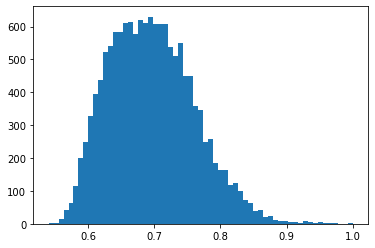

In [10]:
l,g = right_target_global_centrality_t(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)
plt.hist(g[:n], bins = 'auto')

[14464, 14473, 15557, 15594, 15809, 15894, 15906, 15912, 16100, 16397, 16544, 16546, 16556, 16832, 16843, 16938, 17013, 17019, 17102, 17318, 17342, 17556, 17636, 17776, 17858, 17877, 18070, 18077, 18121, 18176, 18426, 18520, 18714, 18733, 18877, 19008, 19086, 19152, 19580, 19683, 19838, 19942, 20089, 20113, 20172, 20479, 20568, 20570, 20628, 20708, 20717, 20783, 20893, 21089, 21190, 21312, 21319, 21351, 21456, 21635, 21741, 21832, 21853, 21921, 21970, 22055, 22169, 22209, 22302, 22331, 22334, 22525, 22795, 22819, 22913, 22931, 22982, 23043, 23048, 23064, 23124, 23201, 23205, 23223, 23311, 23428, 23616, 23717, 23727, 23822, 23823, 23999, 24051, 24059, 24175, 24189, 24194, 24207, 24220, 24295, 24330, 24392, 24508, 24516, 24548, 24604, 24696, 24700, 24804, 24959, 25019, 25071, 25079, 25088, 25126, 25261, 25267, 25362, 25588, 25653, 25697, 25785, 25825, 26163, 26190, 26284, 26375, 26539, 26550, 26560, 26586, 26599, 26771, 26836, 26839, 26947, 27169, 27238, 27254, 27281, 27302, 27308, 27316

(array([ 9., 17., 20., 25., 42., 35., 16., 19., 10.,  8.,  5.,  2.,  4.,
         1.,  1.,  0.,  1.]),
 array([0.00224236, 0.00224599, 0.00224961, 0.00225324, 0.00225686,
        0.00226049, 0.00226412, 0.00226774, 0.00227137, 0.00227499,
        0.00227862, 0.00228224, 0.00228587, 0.00228949, 0.00229312,
        0.00229675, 0.00230037, 0.002304  ]),
 <BarContainer object of 17 artists>)

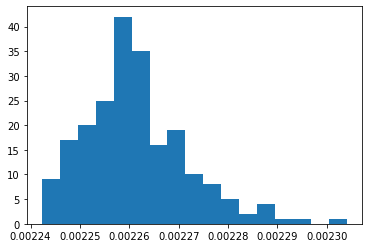

In [11]:
mapped_target_indices = [n+ind for ind in target_genes_indices]

print(mapped_target_indices)

plt.hist(l[mapped_target_indices], bins = 'auto')

In [12]:
#plt.hist(l[n:], bins = 'auto')

In [13]:
def plot_k_curve(genes, cen_vector, ground_truth_genes, filtered):
    secreted_proteins = list(pd.read_csv("../data/002790_proteins_humans.csv", header=None).values)
    secreted_proteins = [s[0].upper() for s in secreted_proteins]
    order = cen_vector[:n].argsort()
    ranks = order.argsort()
    d = {'gene_name': genes, 'centrality': cen_vector[:n], 'rank': n-ranks}
    results = pd.DataFrame(data=d)
    results = results.sort_values(by=['centrality'], ascending=False)
    ranked_genes = results['gene_name'].tolist()
    
    filtered_results = results[results.gene_name.isin(secreted_proteins)]
    filtered_ranked_genes = filtered_results['gene_name'].tolist()
    
    if filtered:
        n_filtered = filtered_results.shape[0]
        k_range = np.arange(n_filtered)
        hits=np.zeros_like(k_range)
        current_hit_count = 0
        for i in k_range:
            if filtered_ranked_genes[i] in ground_truth_genes:
                current_hit_count = current_hit_count +1
            hits[i] = current_hit_count
        random_curve = np.cumsum(np.full((n_filtered,), hits[-1]/n_filtered))
        plot_variables = {'recall_at_k': hits, 'random_curve': random_curve}
        plot_df = pd.DataFrame(data=plot_variables)
        sns.lineplot(data=plot_df)    

    else:    
        k_range = np.arange(n)
        hits=np.zeros_like(k_range)
        current_hit_count = 0
        for i in k_range:
            if ranked_genes[i] in ground_truth_genes:
                current_hit_count = current_hit_count +1
            hits[i] = current_hit_count
        random_curve = np.cumsum(np.full((n,), hits[-1]/n))
        plot_variables = {'query-set centrality': hits, 'random_curve': random_curve}
        plot_df = pd.DataFrame(data=plot_variables)
        sns.lineplot(data=plot_df)    
        #plt.xlabel("Top k predictions", labelpad=1)
        #plt.ylabel("Recall at k", labelpad=1)
        plt.xticks(np.arange(0, 15001, 3500))


        plt.savefig("./insulin_producing_results_corr_SNAP.svg", dpi=300, fontsize=17, bbox_inches = 'tight')
        max_area = (current_hit_count * (current_hit_count + 1))/2 + ((n - current_hit_count)* current_hit_count)
        method_area = np.sum(hits)
        print("Area under curve is: ", (method_area/max_area)) 

        #plt.title("My Daily Step Count Tracked by Fitbit", y=1.02, fontsize=22);

    #get lncRNAs ranking
    lncRNAs = list(np.load("../data/paper/lncRNAs.npy"))
    lncRNA_results = results[results.gene_name.isin(lncRNAs)]
    lncRNA_ranked_genes = lncRNA_results['gene_name'].tolist()

    print(hits[-1])
    return (plot_df,results, filtered_results, lncRNA_results)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later


Area under curve is:  0.6768168150499618
156
(14459, 3)


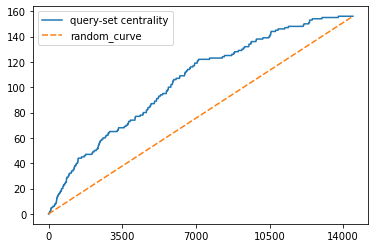

In [14]:
plot_df,results, filtered_results, lncRNA_results = plot_k_curve(genes, g, ground_truth_genes=common_source_genes, filtered=False)
print(results.shape)

117
(14459, 3)


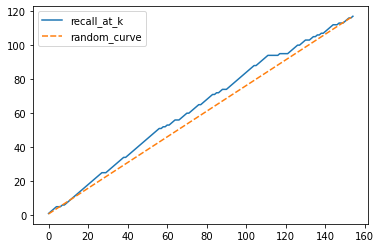

In [15]:
plot_df,results, filtered_results, lncRNA_results = plot_k_curve(genes, g, ground_truth_genes=common_source_genes, filtered=True)
print(results.shape)

In [16]:

lncRNA_results

,gene_name,centrality,rank
11430,LINC00672,0.886263,57
6728,HOXA-AS2,0.856091,157
3932,PRR34-AS1,0.843878,234
11570,MIR22HG,0.825184,443
5572,LINC00294,0.815562,605
...,...,...,...
1867,LINC01239,0.576366,14349
6727,LINC00431,0.573189,14381
1105,SCOC-AS1,0.568862,14407
4986,STK4-AS1,0.567493,14415


In [18]:
np.shape(genes)

(14459,)

In [19]:
lncRNA_results.to_csv("../data/paper/insulin_lncRNA_results_corr_SNAP.csv")

In [20]:
filtered_results.to_csv("../data/paper/insulin_fileterd_results_corr_SNAP_0.9.csv")

In [21]:
results.to_csv("../data/paper/insulin_results_corr_SNAP_0.9.csv")
